<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/TIme_Seris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pmdarima

In [2]:
from pandas import read_csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Try 'utf-8' encoding first
ts = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv', encoding='utf-8').filter(['날짜', '전일대비증감수'])

# If 'utf-8' fails, try 'cp949'
if ts is None:
  ts = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv', encoding='cp949').filter(['날짜', '전일대비증감수'])

ts['날짜'] = ts['날짜'].astype('datetime64[ns]') #날짜 데이터로 설정, nanoseconds 단위 명시
ts = ts.set_index('날짜') #인덱스를 날짜로 셋팅
ts_head = ts.head(334) # 2021년 1~11월 데이터
ts_tail = ts.tail(31) # 2021년 12월 데이터
print(ts_head)

            전일대비증감수
날짜                 
2021-01-01      357
2021-01-02      250
2021-01-03      198
2021-01-04      329
2021-01-05      199
...             ...
2021-11-26     1742
2021-11-27     1888
2021-11-28     1676
2021-11-29     1393
2021-11-30     1186

[334 rows x 1 columns]


#### 🕰️ 시계열 데이터의 특성

###### 🔄 정상성 : 평균과 분산이 일정/ 추세나 계절성을 가지지 않음
        * ADF, KPSS, ACF 그래프로 확인
        * ADF
           귀무가설: 단위근이 있다. 대립 가설 : 단위근이 없다.
        * KPSS
           귀무가설: 단위근이 없다. 대립 가설 : 단위근이 있다.
        * 해석) ACF 그래프 : Time Lag가 증가할 수록 0으로 빠르게 떨어지고, 비정상성 데이터의 ACF그래프는 느리게 감소한다.


###### 🛠️ [정상화 방법]
        * 평균 - 차분
        * 분산 - 로그변환, 제곱근 변환, Box-cox 등의 변환

ADF Statistic : 0.7623135388299538
P-value : 0.9910028277484191

ADF Statistic : 2.2098185510810606
P-value : 0.01


<ipython-input-3-94734216eef7>:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss = kpss(ts_head, regression ='c', nlags = 'auto')


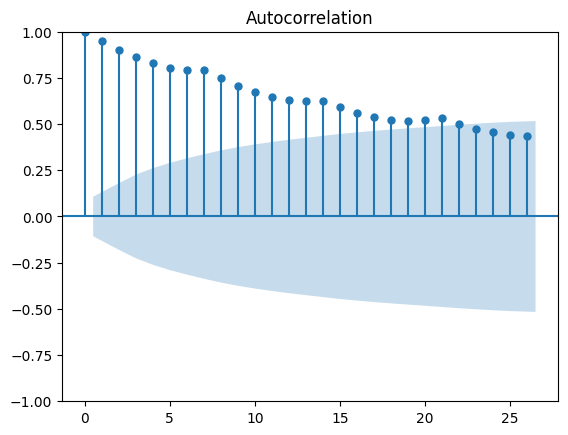


X축이 시차일때, 값이 빠르게 떨어지지 않기 때문에 비정상 데이터로 본다.



In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


# 단위근이 있다 (비정상)
# 단위근이 없다 (정상)

result = adfuller(ts_head, regression = 'c', autolag = 'AIC')
print(f"ADF Statistic : {result[0]}")
print(f"P-value : {result[1]}")
#단위근이 있다. (비정상 데이터)


# Kpss
# 단위근이 없다
# 단위근이 있다.
print("")
kpss = kpss(ts_head, regression ='c', nlags = 'auto')
print(f"ADF Statistic : {kpss[0]}")
print(f"P-value : {kpss[1]}")

# 정상성 그래프
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_head)
plt.show()


print("""
X축이 시차일때, 값이 빠르게 떨어지지 않기 때문에 비정상 데이터로 본다.
""")

#### 🕰️ 자기 상관

###### 🔄 자기상관
* 일정 기간 (lag)만큼 이동시킨 데이터와 비교하여, 상관 관계 측정
* 패턴, 계절성이 있는지 확인
* 과거의 데이터가 미래를 예측하는데 얼마나 영향을 미치는가? 를 해석

        * ACF,PACF, 융박스 검정, 더빗완슨 검정
        * ACF  
           Lag에 따른 관측치들의 관련성을 측정
           X축 : 시차, Y축 : 자기 상관
           Y축 값이 임계 영역을 벗어나면 자기 상관이 존재  
        * PACF
           k 이외의 모든 다른 시점 관측치의 영향력을 배제
           어느 시차의 데이터와 자기 상관을 가지는 지확인  
        * 귀무가설 : 자기 상관이 없다
        * 대립가설 : 자기 상관이 있다.

        * 더빗완슨 : 2 자기 상관이 없다. 0 양 / 4 음


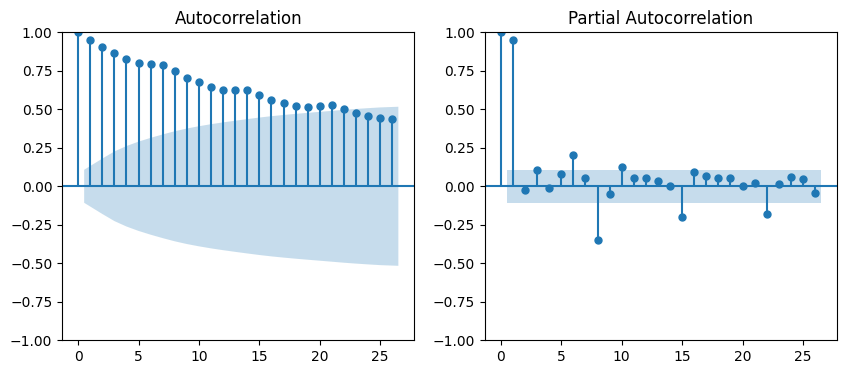



1. ACF : lag(시차)가 증가할 수록 자기 상관이 서서히 낮아지는 형태
         '과거의 값과 게속해서 유의미한 상관을 가지지만, 시간이 지날 수록 서서히 약해지는 경향'
         파란 영역을 벗어나는 통계적으로 유의하다고 판단하며 자기 상관이 있음을 나타낸다.
         즉, 한 시점의 값이 그 이전 여러 시점에 걸쳐 영향을 받는 패턴이다.
         ACF가 천천히 감소하는 패턴은 AR(자기 회귀) 성분이 있을 때 나타난다.


2. PCF : 1,3, 6,,8의 시차에 자기 상관이 존재
         LAG 1 일때 임계영역을 뚜렷히 벗어나며  AR(1) 모형이다. 즉, AR(1)일때 데이터의 자기 상관 구조를 잘 설명한다.

0 1.0 1.0
1 0.8464546288657141 1.0609435443336521
2 0.7271983753294582 1.0873280043011393
3 0.6464022467794888 1.0996461471083732
융박스 검정
       lb_stat      lb_pvalue
1   304.691106   3.131578e-68
2   579.605498  1.381228e-126
3   833.394832  2.474556e-180
4  1067.333259  9.111938e-230
5  1286.641140  5.005454e-276

[0.03337102]


In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

fig, ax = plt.subplots(1,2, figsize = (10, 4))
plot_acf(ts_head, ax = ax[0])
plot_pacf(ts_head, ax = ax[1])
plt.show()

print("""

1. ACF : lag(시차)가 증가할 수록 자기 상관이 서서히 낮아지는 형태
         '과거의 값과 게속해서 유의미한 상관을 가지지만, 시간이 지날 수록 서서히 약해지는 경향'
         파란 영역을 벗어나는 통계적으로 유의하다고 판단하며 자기 상관이 있음을 나타낸다.
         즉, 한 시점의 값이 그 이전 여러 시점에 걸쳐 영향을 받는 패턴이다.
         ACF가 천천히 감소하는 패턴은 AR(자기 회귀) 성분이 있을 때 나타난다.


2. PCF : 1,3, 6,,8의 시차에 자기 상관이 존재
         LAG 1 일때 임계영역을 뚜렷히 벗어나며  AR(1) 모형이다. 즉, AR(1)일때 데이터의 자기 상관 구조를 잘 설명한다.
""")
acs, confs = acf(ts_head, fft = False, nlags= 3, alpha = 0.05, adjusted = True)

for lag, ac, conf  in zip(range(3+1), acs, confs) :
  print(lag, conf[0] , conf[1])


## 검증 - Ljung-box test
# 귀무 : 데이터가 일련의 상관 관계를 가지지 않는다.
# 대립 : 데이터가 일련의 상관 관계를 가진다.

from statsmodels.stats.diagnostic import acorr_ljungbox
box = acorr_ljungbox(ts_head, return_df = True, auto_lag = True).head()
print("융박스 검정")
print(box)
print("")


# 검증 - Durbin Watson
# 2 : 상관 없다
# 0 : + 의 상관 / 4 : -의 상관
from statsmodels.stats.stattools import durbin_watson
durbin = durbin_watson(ts_head)
print(durbin)

#### 📈  분해
* 목적)
  - 노이즈 식별, 패턴의 이해
  - 시계열 모형의 적합성 판단

###### 🔄 개념 : 추세/계절/불규칙성 /순환 등의 요소로 나누어 분석
        🛠️ [방식]
        1) 이동 평균법 (추세, 순환)
        - 일정 기간 별 이동 평균을 계산 > 계절, 불규칙 제거 / 추세, 순환만 가지는 시계열로 분해
        - 단기 예측, 완만한 추세를 보일때, 노이즈 제거

        2) 지수평활법
        - 불규칙제거, 모든 시계열 자료를 사용하여 평균을 구해, 최근 시계열에 더 많은 가중치를 부여

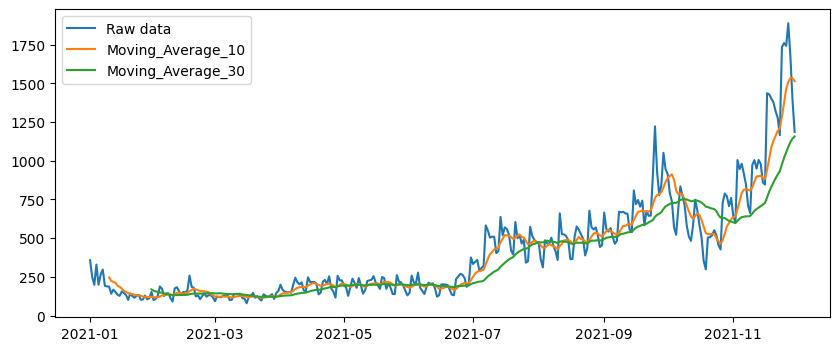

In [5]:
# 1) 이동 평균법 - 추세와 순환을 가진 시계열로 분해

moving_average10 = ts_head.rolling(window = 10).mean().dropna()
moving_average30 = ts_head.rolling(window = 30).mean().dropna()

plt.figure(figsize=(10, 4))
plt.plot(ts_head, label = 'Raw data')
plt.plot(moving_average10, label = 'Moving_Average_10')
plt.plot(moving_average30, label = 'Moving_Average_30')
plt.legend()

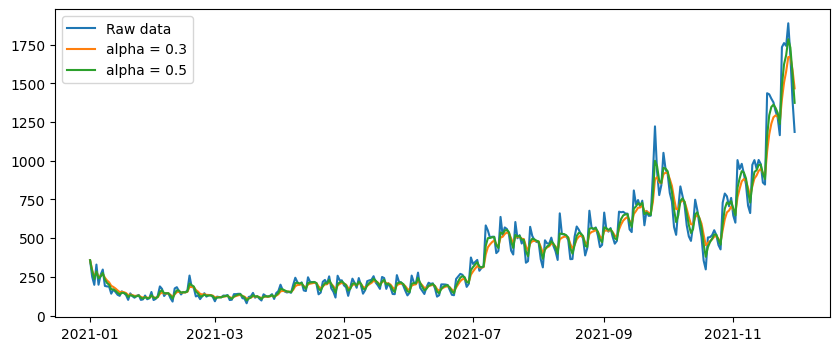

In [6]:
# 지수 평활법 : 불규칙 변경 제거
ewm03 = ts_head.ewm(alpha = 0.3).mean()
ewm05 = ts_head.ewm(alpha = 0.5).mean()

plt.figure(figsize=(10, 4))
plt.plot(ts_head, label = 'Raw data')
plt.plot(ewm03, label = 'alpha = 0.3')
plt.plot(ewm05, label = 'alpha = 0.5')
plt.legend()

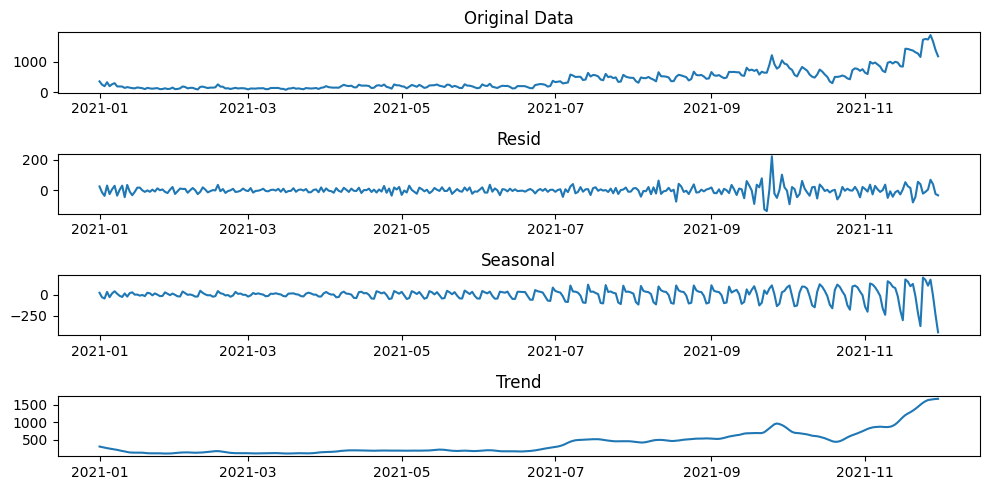

In [7]:
## STL 분해 = 계절, 추제, 잔차로 분해하여 각각 살펴 볼 수 있음

from statsmodels.tsa.seasonal import STL

stl = STL(ts_head, seasonal = 7, trend = 9).fit()
# 잔차
resid = stl.resid
# 계절적 요소
seasonal = stl.seasonal
# 트렌드 요소
trend = stl.trend

fig, axes = plt.subplots(4,1, figsize = (10, 5))

axes[0].plot(ts_head)
axes[0].set_title('Original Data')
axes[1].plot(resid)
axes[1].set_title('Resid')
axes[2].plot(seasonal)
axes[2].set_title('Seasonal')
axes[3].plot(trend)
axes[3].set_title('Trend')

plt.tight_layout()
plt.show()

#### 📈  업 샘플링/ 다운 샘플링
      - 날짜의 빈도를 늘리거나, 줄여 데이터를 규칙적인 형태로 변환

In [8]:
df = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv', encoding='utf-8')
df.head()

,날짜,누적확진자수,전일대비증감수
0,2021.1.1,19352,357
1,2021.1.2,19602,250
2,2021.1.3,19800,198
3,2021.1.4,20129,329
4,2021.1.5,20328,199


In [9]:
# 날짜 변환
df['날짜'] = pd.to_datetime(df['날짜'])
df1 = df.set_index('날짜')

# rule = 'A(년)', 'M(월)', 'D(일))', 'T(분)'='min(분)' 'S(초)', 'Q(분기)', 'W(주)'
print(ts.resample(rule = 'QE').asfreq())
print(ts.resample(rule = 'QE').sum())
print(ts.resample(rule = 'QE').mean())

            전일대비증감수
날짜                 
2021-03-31      158
2021-06-30      375
2021-09-30      945
2021-12-31     1670
            전일대비증감수
날짜                 
2021-03-31    13034
2021-06-30    17957
2021-09-30    50508
2021-12-31   124799
                전일대비증감수
날짜                     
2021-03-31   144.822222
2021-06-30   197.329670
2021-09-30   549.000000
2021-12-31  1356.510870


#### 📈  시계열 결측치 처리

    1) forward fill : 직전의 값으로  채우기
    2) backward fill : 직후의 값으로  채우기
    3) 이동 평균
    4) 보간법

```python

linear = ts_na.interpolate(method='linear')
nearest = ts_na.interpolate(method='nearest')
zero = ts_na.interpolate(method='zero')
quadratic = ts_na.interpolate(method='quadratic') # polynomial order=2와 동일
cubic = ts_na.interpolate(method='cubic') # polynomial order=3과 동일
spline = ts_na.interpolate(method='spline', order=2)
polynomial = ts_na.interpolate(method='polynomial', order=3)

```

#### 📈  차분 & 변환
    
      데이터가 정상성을 가지지 않을 때, 필요한 전처리

  Number of Diff     P_val
0         1 Diff  0.003625
1         2 Diff  0.004661
2         3 Diff  0.000737
3         4 Diff  0.073955
1번의 차분으로 단위근이 없는 정상으로 만들 수 있다


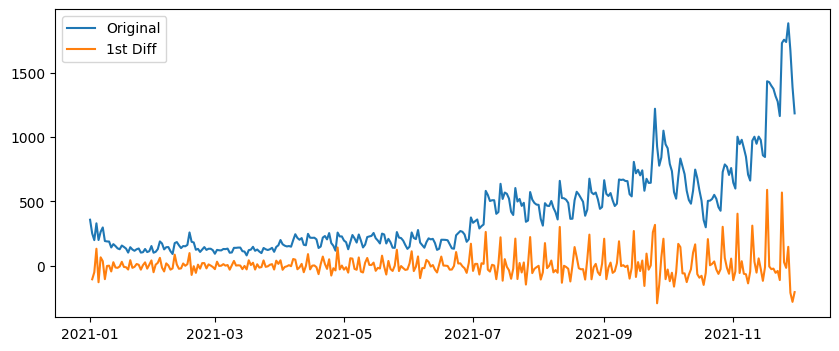

In [10]:
## 차분
# 단위근이 있다 (비정상)
# 단위근이 없다 (정상)

ad_lst = []
for i in range(1,5) :
  diff_df = ts_head.diff(periods = i).dropna()

  ad = adfuller(diff_df)
  ad_lst.append([f"{i} Diff", ad[1]])

print(pd.DataFrame(ad_lst, columns = ['Number of Diff' , 'P_val']))
print("1번의 차분으로 단위근이 없는 정상으로 만들 수 있다")

diff1 = ts_head.diff(periods = 1).dropna()

plt.figure(figsize = (10, 4))

plt.plot(ts_head, label = 'Original')
plt.plot(diff1, label = '1st Diff')
plt.legend()
plt.show()

[0.9910028277484191]
[0.0007278939174731419]
[0.0003760394629491767]


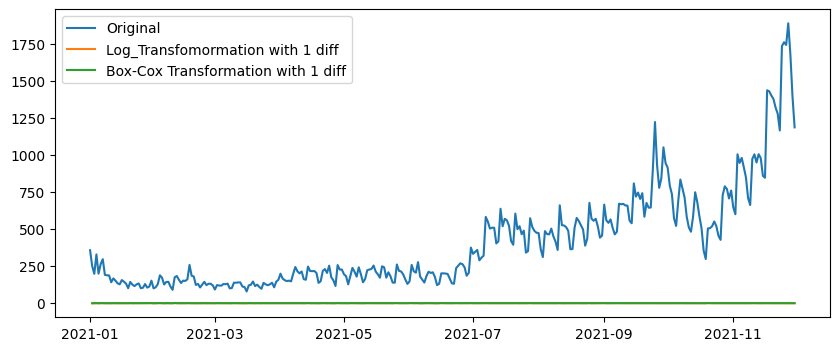

In [11]:
## 변환 - 로그/ 박스 콕스 등의 변환
from sklearn.preprocessing import PowerTransformer
import numpy as np

# 1) 로그 변환
log = np.log(ts_head)

# 2) 박스콕스 변환
pt = PowerTransformer(method = 'box-cox')
box = pd.DataFrame(pt.fit_transform(ts_head), index = ts_head.index,  columns = ['전일대비증감수'])



# 3) 각 차분
log = log.diff(1).dropna()
box = box.diff(1).dropna()

# 4) 시각화
name = [ts_head, log, box]
lst = ['ts_head', 'log', 'box']

result =[]
for data in name:
    values = data['전일대비증감수'].values
    ad = adfuller(values)[1]

    print([ad])

plt.figure(figsize = (10, 4))

plt.plot(ts_head, label = 'Original')
plt.plot(log, label = 'Log_Transfomormation with 1 diff')
plt.plot(box, label = 'Box-Cox Transformation with 1 diff')
plt.legend()
plt.show()

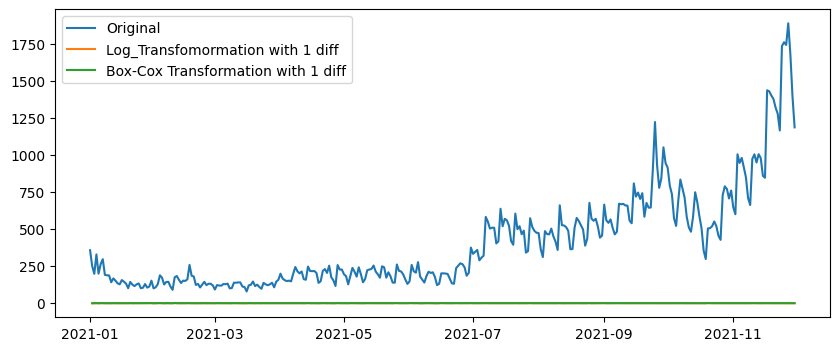

In [12]:
plt.figure(figsize = (10, 4))

plt.plot(ts_head, label = 'Original')
plt.plot(log, label = 'Log_Transfomormation with 1 diff')
plt.plot(box, label = 'Box-Cox Transformation with 1 diff')
plt.legend()
plt.show()

##### 📈 시계열 모델링 및 평가


##### 1) Box-Jenkins 와 ARIMA
  * 정상 여부와 계절성 확인
  * 정상성 : 차분과 변환
  * p,q 찾기
      - ACF/PACF 그래프를 통해 AR/ MA의 p,q를 확인
      - AR(p) : ACF 값이 천천히 감수, q 이후에 빠르게 감소
      - MA(q) : ACF 값이 q 이후 빠르게 감소, PACF천천히 감소
      

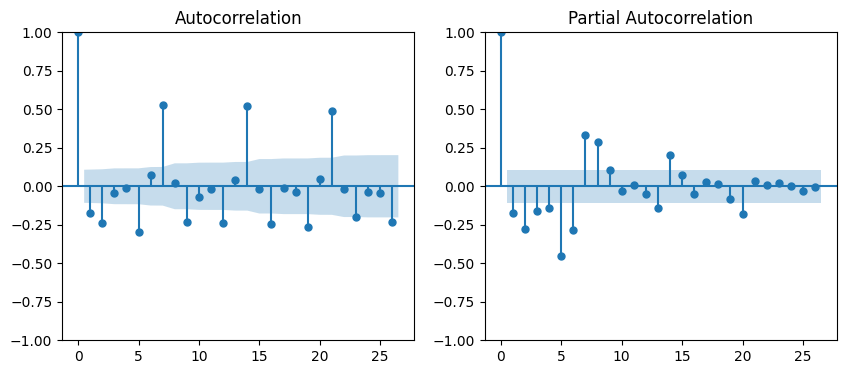


AR(p) = 9 
  PACF 차트 : Lag 9에서 까지 의미있게 크거나 작고, 그 이후에는 0으로 가까워지는 형태 AR(9)
MA(q) = 2 
  AR 차트 : LAG가 3일때 0근처로 수렴하면 MA(2)를 선택한다. 



In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# box : box-cox 로 변환한 데이터 사용
fig, axes = plt.subplots(1,2 , figsize = (10, 4))

plot_acf(box, ax = axes[0])
plot_pacf(box, ax = axes[1])

plt.show()

print("""
AR(p) = 9
  PACF 차트 : Lag 9에서 까지 의미있게 크거나 작고, 그 이후에는 0으로 가까워지는 형태 AR(9)
MA(q) = 2
  AR 차트 : LAG가 3일때 0근처로 수렴하면 MA(2)를 선택한다.
""")

#### 📈  ARIMA VS SARIMAX

    1) ARIMA - 기본적인 비계절 시계열 모델 (p, d, q)
    2) SARIMAX - 계절성을 고려하는 모델 (p, d, q)(P,D,Q,s) + X


In [14]:
#!pip install statsmodels --upgrade
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA 모델에 seasonal_order를 넣으면 SARIMAX
model = ARIMA(ts_head, order = (9, 1, 2), seasonal_order = (0,0,1,7))

fit = model.fit()
# 잔차의 정규성 : Jarque-Bear 귀무가설 채택, 정규성을 갖는다
# 잔차의 자기 상관 확인 : Ljung-Box 귀무가설 채택, 자기 상관이 없다

resid = fit.resid

# 31 개의 날짜 값을 예측
pred_31 = fit.forecast(31)
print(fit.summary())



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(9, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1854.018
Date:                           Sat, 22 Mar 2025   AIC                           3734.036
Time:                                   15:47:31   BIC                           3783.542
Sample:                               01-01-2021   HQIC                          3753.777
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0276      1.000     -0.028      0.978      -1.988       1.933
ar.L2         -0.1713      0.496     -0.346

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 📈  차수 (P, D, Q) 찾기

In [15]:
# 자동 차수 선택1 - pmdarima의 auto_arima
#from pmdarima import auto_arima
#auto_arima(ts_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5,
#           max_Q=5, m=7, seasonal=True, trace=False, error_action='warn', suppress_warnings=True)

#### ✅ 연습 문제

##### 📌 1) 주 단위 평균 가격으로 다운 샘플링, 앞의 데이터 300개를 down_head, 뒤의 데이터 14개를 down_tail로 분할

In [16]:
# 시계열
from scipy import interpolate  # 결측치 - 보간법

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf


# 시계열 시각화
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools

In [17]:
from pandas import read_csv
df = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice12_ms_stock.csv', encoding='euc-kr')

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42


In [18]:
# 다운 샘플링
sample = df.resample('W').mean()

down_head = sample.head(300)
down_tail = sample.tail(14)

##### 📌 2) EDA

<Axes: xlabel='Date'>

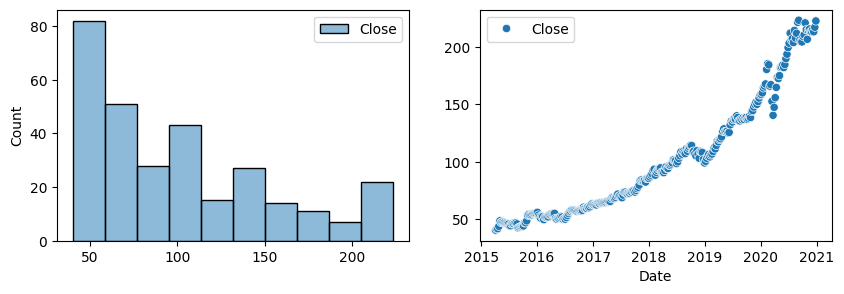

In [26]:
# down_head - LIne, Scatter, Bar
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1,2, figsize = (10,3))
sns.histplot(down_head, ax = ax[0])
sns.scatterplot(down_head, ax = ax[1])

##### 📌 3) Model

0.998913687800196
비정상 시계열이다


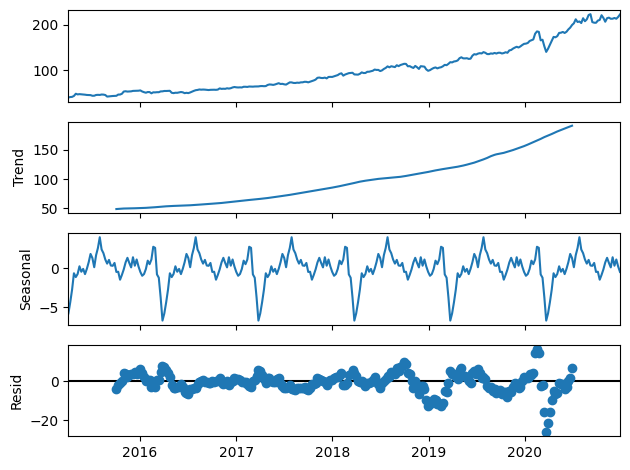


1) 첫번쨰 그래프 : 원 데이터의 그래프로 시간이 지날 수록 상승세 
2) 추세 : 점점 상승하는 경향
3) 계절성 : 일정 패턴으로 계절적 요인이 있는 것으로 보임 
4) 불규칙 :평균이 0부근에서 랜덤하게 분포하는지 확인 할 수 있다. 

데이터가 추세, 계절성을 가지고 있기 때문에 차분/변환을 통해 정상성을 확보 한 후 모델에 적용하는것이 필요해보인다.



In [27]:
# 1) 정상성 검토
# adufuller
# 귀무 : 비정상
# 대립 : 정상


adu = adfuller(down_head, regression ='c', autolag = 'AIC')
print(adu[1])
print("비정상 시계열이다")

# 시계열 분해

decomposition = sm.tsa.seasonal_decompose(down_head)
decomposition.plot()
plt.show()

print("""
1) 첫번쨰 그래프 : 원 데이터의 그래프로 시간이 지날 수록 상승세
2) 추세 : 점점 상승하는 경향
3) 계절성 : 일정 패턴으로 계절적 요인이 있는 것으로 보임
4) 불규칙 :평균이 0부근에서 랜덤하게 분포하는지 확인 할 수 있다.

데이터가 추세, 계절성을 가지고 있기 때문에 차분/변환을 통해 정상성을 확보 한 후 모델에 적용하는것이 필요해보인다.
""")

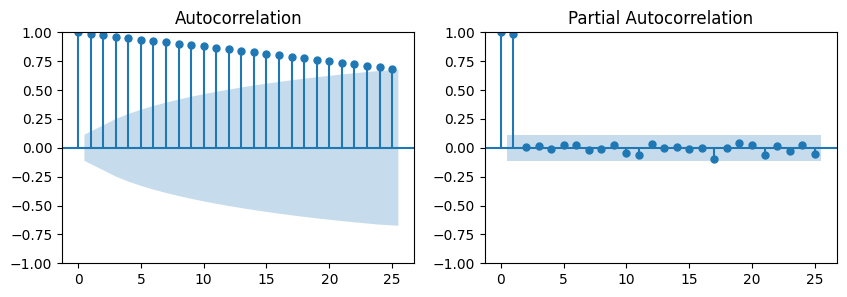


ACF 그래프가 천천히 감소하는 것으로 보아, 비정상 데이터 임을 확인 할 수 있다. 
ACF 그래프에서 파란색 음영을 벗어나는 부분이 다수를 이루는것으로 보아 여러 지연 구간에 걸처 강한 자기 상관이 존재한다. 
이는 비정상 시계열이나 추세가 제거되지 않은 데이터 일때 자주 보이는 패턴이다. 

PACF 그래프는 전체적으로 0에 근접하고 있으며 AR (자기 회귀) 구조가 뚜렷하지 않다는 해석을 할 수 있다. 



In [30]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
plot_acf(down_head, ax=ax[0])
plot_pacf(down_head, ax=ax[1])
plt.show()

print("""
ACF 그래프가 천천히 감소하는 것으로 보아, 비정상 데이터 임을 확인 할 수 있다.
ACF 그래프에서 파란색 음영을 벗어나는 부분이 다수를 이루는것으로 보아 여러 지연 구간에 걸처 강한 자기 상관이 존재한다.
이는 비정상 시계열이나 추세가 제거되지 않은 데이터 일때 자주 보이는 패턴이다.

PACF 그래프는 전체적으로 0에 근접하고 있으며 AR (자기 회귀) 구조가 뚜렷하지 않다는 해석을 할 수 있다.
""")

In [53]:
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs, nsdiffs  #차분횟수 자동 추정


# 계절 차분 차수
D = nsdiffs(down_head, m=12, test='ocsb')  # OCSB 테스트로 계절성 확인
print(f"추천 계절 차분 횟수 D = {D}")

# 비계절 차분 차수
d = ndiffs(down_head, test='adf')  # ADF 기준
print(f"추천 비계절 차분 횟수 d = {d}")


# log 변환 - 8번 차분
log = np.log(down_head)
log_diff8 = log.diff(8).dropna()

from pmdarima import auto_arima
auto_arima(down_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7,
           seasonal=True, trace=False, error_action='warn', suppress_warnings=True)

추천 계절 차분 횟수 D = 0
추천 비계절 차분 횟수 d = 1


ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [54]:

arima = ARIMA(down_head, order = (3,1,2), seasonal_order= (1,0,1,7))
fit = arima.fit()
print(fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  300
Model:             ARIMA(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -770.520
Date:                           Sat, 22 Mar 2025   AIC                           1557.040
Time:                                   16:05:09   BIC                           1586.643
Sample:                               04-05-2015   HQIC                          1568.888
                                    - 12-27-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1252      0.083      1.502      0.133      -0.038       0.289
ar.L2          0.9917      0.049     20.099

##### 📌 4) 평가
```python
from sklearn import metrics

def mae(y_true, y_pred):
    return metrics.mean_absolute_error(y_true,y_pred) #MAE
def mse(y_true, y_pred):
    return metrics.mean_squared_error(y_true,y_pred) # MSE
def rmse(y_true, y_pred):    
    return np.sqrt(metrics.mean_squared_error(y_true,y_pred))  # RMSE
def r2(y_true, y_pred):    
    return metrics.r2_score(y_true,y_pred) # R2
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100 # MAPE

def get_score(model, y_true, y_pred):
    model = model
    mae_val = mae(y_true, y_pred)
    mse_val = mse(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    r2_val = r2(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    
    score_dict = {"model": model,
                  "mae" :  mae_val,
                  "mse" :  mse_val,
                  "rmse" : rmse_val,
                  "r2":    r2_val,
                  "mape" : mape_val
                 }
    return score_dict

```


5.9345903864514815


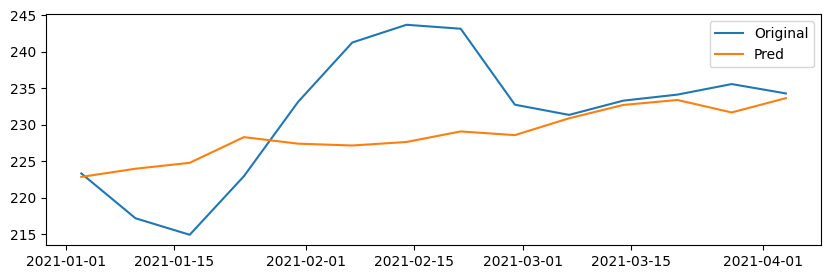

In [59]:
from sklearn.metrics import r2_score , mean_absolute_error

def mae(y_true, y_pred):
    return mean_absolute_error(y_true,y_pred)

pred = fit.predict(start = down_tail.index[0],
            end = down_tail.index[-1])


print(mae(down_tail, pred))

fig, ax = plt.subplots(figsize = (10, 3))

plt.plot(down_tail, label = 'Original')
plt.plot(pred, label = 'Pred')
plt.legend()
plt.show()